In [5]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import re


In [13]:
AUDIO_PATH = "../AUDIO_DATA"
AUDIO_LIST = sorted(os.listdir(AUDIO_PATH))
set([re.split('_|%',i)[3] for i in AUDIO_LIST])
print(AUDIO_LIST)

['20240929_023338_Dona_75-85%output.wav', '20240929_023344_Dona_75-85%output.wav', '20240929_023348_Dona_75-85%output.wav', '20240929_023353_Dona_75-85%output.wav', '20240929_023359_Dona_75-85%output.wav', '20240929_023409_Dona_75-85%output.wav', '20240929_023414_Dona_75-85%output.wav', '20240929_023418_Dona_75-85%output.wav', '20240929_023426_Dona_75-85%output.wav', '20240929_023431_Dona_75-85%output.wav', '20240929_023435_Dona_75-85%output.wav', '20240929_023439_Dona_75-85%output.wav', '20240929_023443_Dona_75-85%output.wav', '20240929_023447_Dona_75-85%output.wav', '20240929_023501_Dona_75-85%output.wav', '20240929_023505_Dona_75-85%output.wav', '20240929_023509_Dona_75-85%output.wav', '20240929_023513_Dona_75-85%output.wav', '20240929_023517_Dona_75-85%output.wav', '20240929_023521_Dona_75-85%output.wav', '20240929_023541_Dona_95-Ripeoutput.wav', '20240929_023702_Dona_95-Ripeoutput.wav', '20240929_023705_Dona_95-Ripeoutput.wav', '20240929_023710_Dona_95-Ripeoutput.wav', '20240929_0

In [15]:
from pathlib import Path
(Path(AUDIO_PATH)/AUDIO_LIST[0]).exists()

True

C:\Users\Tom\AppData\Local\Temp\ipykernel_11100\1617714703.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(AUDIO_PATH + '/' + AUDIO_LIST[0], sr=None)
c:\Users\Tom\Documents\Durian_internship\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\Tom\AppData\Local\Temp\ipykernel_11100\1617714703.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr1 = librosa.load(AUDIO_PATH + '/20240929_024435_Dona_95-Ripeoutput.wav', sr=None)


0.0 22050.0 11025.0 40596009.521484375


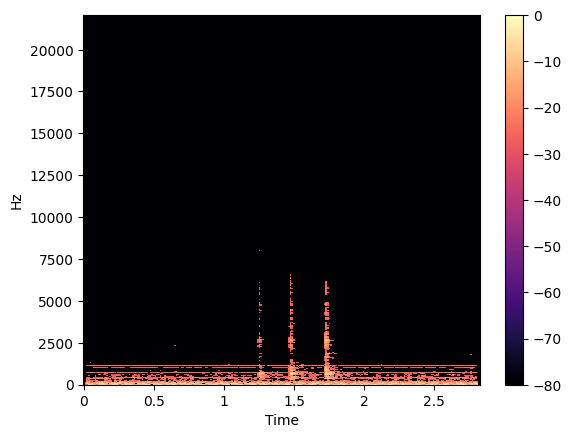

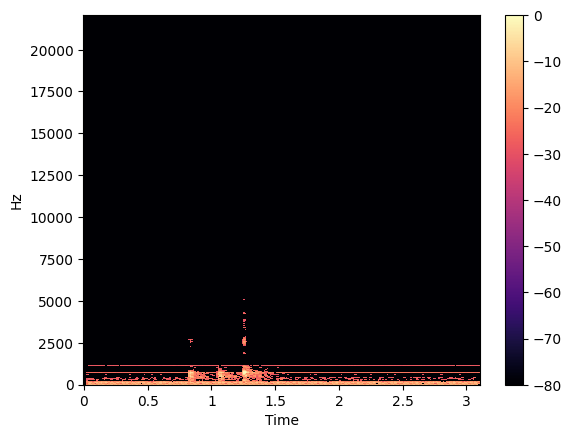

In [53]:
y, sr = librosa.load(AUDIO_PATH + '/' + AUDIO_LIST[0], sr=None)
x, sr1 = librosa.load(AUDIO_PATH + '/20240929_024435_Dona_95-Ripeoutput.wav', sr=None)
frequencies = librosa.fft_frequencies(sr=sr)
print(min(frequencies), max(frequencies), sum(frequencies)/len(frequencies), np.var(frequencies))


D = librosa.stft(y)
S_db1 = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db1_thresh = np.where(S_db1 > -30, S_db1, -80)
plt.figure()
librosa.display.specshow(S_db1_thresh, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()

D2 = librosa.stft(x)
S_db2 = librosa.amplitude_to_db(np.abs(D2), ref=np.max)
S_db2_thresh = np.where(S_db2 > -30, S_db2, -80)
plt.figure()
librosa.display.specshow(S_db2_thresh, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()

📍 Pic max = 0.00 dB à 646.00 Hz, temps ≈ 1.49 s


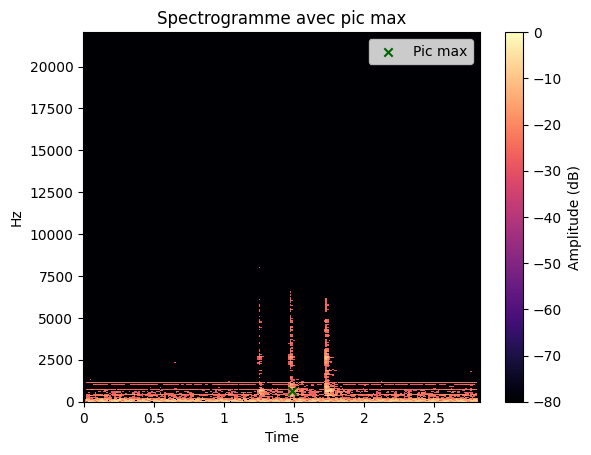

In [73]:
# Trouver l’indice (i, j) du max dans le spectrogramme seuillé
max_index = np.unravel_index(np.argmax(S_db1_thresh, axis=None), S_db1_thresh.shape)

# Récupérer la fréquence (ligne) et le temps (colonne)
freq_at_max = frequencies[max_index[0]]
time_at_max = max_index[1] * 512 / sr  
# Valeur dB max
val_db_max = S_db1_thresh[max_index]

print(f"📍 Pic max = {val_db_max:.2f} dB à {freq_at_max:.2f} Hz, temps ≈ {time_at_max:.2f} s")

plt.figure()
librosa.display.specshow(S_db1_thresh, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(label='Amplitude (dB)')

# Ajouter le point du pic max
plt.scatter(time_at_max, freq_at_max, color='darkgreen', marker='x', label='Pic max')
plt.legend()
plt.title("Spectrogramme avec pic max")
plt.show()

